In [119]:
%pylab inline
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Reading LARS02 data & model data from Dijkstra analytical solution

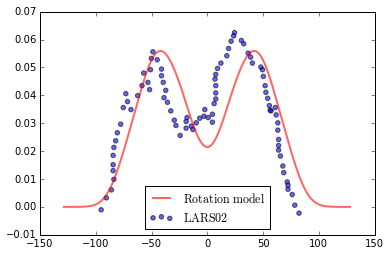

In [143]:
LARS = np.loadtxt("../data/LARS2.txt")
x = LARS[:-17,0]# -17 para no tomar el ruido despues de la linea en las obs
y_0 = LARS[:-17,1]/1.1E2
z = 0.029836
c =  299792.458
x_0 = x - c*z
model = np.loadtxt("model.dat")
x_t = model[:,0]*12.85
y_t = model[:,1]

scatter(x_0, y_0, alpha=0.6, label="$\mathrm{LARS 02}$")
plot(x_t, y_t, c='r', alpha=0.6, label="$\mathrm{Rotation\ model}$", lw=2)
legend(loc="best", fontsize=12)

# Interpolating the teo data to match de obs data

In [121]:
def teo_obs(x_t_, y_t, x_0):
    f = interp1d(x_t, y_t, kind="linear")
    x_new = linspace(min(x_t), max(x_t), 2000)
    y_new = f(x_0)

    return x_0, y_new

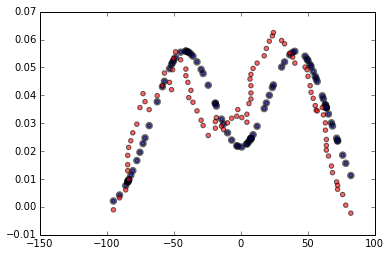

In [144]:
X_r, Y_r = teo_obs(x_t, y_t,x_0 )
scatter(X_r, Y_r, alpha=0.6, lw=3)
scatter(x_0, y_0, c='r', alpha=0.6)

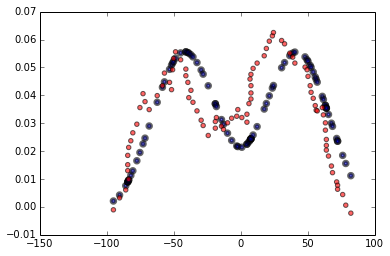

In [146]:
def normalization(y_obs, y_model):
    obs_int = sum(y_obs)
    teo_int = sum(y_model)
    y_model = y_model*obs_int/teo_int
    
    return y_model
Y_r = normalization(y_0, Y_r)
scatter(X_r, Y_r, alpha=0.6, lw=3)
scatter(x_0, y_0, c='r', alpha=0.6)

# Defining likelihood

In [123]:
def likelihood(y_obs, y_model):
    chi_squared = (1.0/2.0)*sum((y_obs-y_model)**2)
    return -chi_squared

# Function that returns the analytic solution 

In [148]:
def my_model(tau, vel, angle, x_0, y_0):
    f = open("values", "w")
    f.write(("%f \t %f \t %f \n")% (tau, vel, angle))
    f.close()
    !./analytic_solution.x > model.dat
    data_m = np.loadtxt("model.dat")
    x_teo = data_m[:,0]*12.85
    y_teo = data_m[:,1]
    x, y = teo_obs(x_teo, y_teo, x_0)
    y = normalization(y_0, y)
    return x, y

# MCMC core

In [149]:
tau_walk = empty((0)) #this is an empty list to keep all the steps
vel_walk = empty((0))
angle_walk = empty((0))
l_walk = empty((0))

tau_walk = append(tau_walk, 100000)
vel_walk = append(vel_walk, 50)
angle_walk = append(angle_walk, 45)

x_init, y_init = my_model(tau_walk[0], vel_walk[0], angle_walk[0], x_0, y_0)
l_walk = append(l_walk, likelihood(y_0, y_init))
print tau_walk
print vel_walk
print angle_walk
print l_walk

100000.000000 50.000000 0.785398
[ 100000.]
[ 50.]
[ 45.]
[-0.0066392]


In [151]:
n_iterations = 20 #this is the number of iterations I want to make
for i in range(n_iterations):
    tau_prime = np.random.normal(tau_walk[i], 1000) 
    vel_prime = np.random.normal(vel_walk[i], 5)
    angle_prime = np.random.normal(angle_walk[i], 5)

    
    x_init, y_init = my_model(tau_walk[i], vel_walk[i], angle_walk[i], x_0, y_0)
    x_prime, y_prime = my_model(tau_prime, vel_prime, angle_prime, x_0, y_0)
    
    l_prime = likelihood(y_0, y_prime)
    l_init = likelihood(y_0, y_init)
    
    alpha = l_prime-l_init
    if(alpha>=0.0):
        tau_walk  = append(tau_walk,tau_prime)
        vel_walk  = append(vel_walk,vel_prime)
        angle_walk  = append(angle_walk,angle_prime)
        l_walk = append(l_walk, l_prime)
    else:
        beta = random.random()
        if(beta<=alpha):
            tau_walk = append(tau_walk,tau_prime)
            vel_walk = append(vel_walk,vel_prime)
            angle_walk  = append(angle_walk,angle_prime)
            l_walk = append(l_walk, l_prime)
        else:
            tau_walk = append(tau_walk,tau_walk[i])
            vel_walk = append(vel_walk,vel_walk[i])
            angle_walk = append(angle_walk,angle_walk[i])
            l_walk = append(l_walk, l_init)

100000.000000 50.000000 0.785398
101181.414066 53.504010 0.666580
101551.675864 54.546627 0.788302
^C


IndexError: too many indices

In [117]:
max_likelihood_id = argmax(l_walk)
best_tau = tau_walk[max_likelihood_id]
best_vel = vel_walk[max_likelihood_id]
best_angle = angle_walk[max_likelihood_id]
print (l_walk[max_likelihood_id])
print best_tau
print best_vel
print best_angle

-0.00618710528881
100911.817777
52.3666500697
45.2313230098


In [152]:
best_x, best_y = my_model(best_tau, best_vel, best_angle, x_0, y_0)

100911.817777 52.366650 0.789436


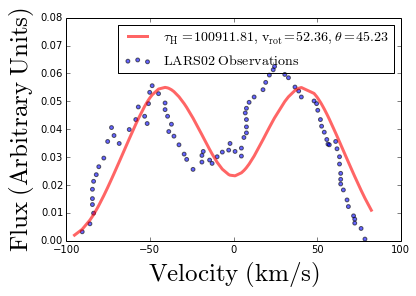

In [165]:
#print len(best_x), len(x_0)
figsize=(15, 12)
scatter(x_0, y_0, alpha=0.6, s=15, label="$\mathrm{LARS02\ Observations}$")
plot(best_x, best_y, c="red", alpha=0.6, lw=3, label=r"$\mathrm{\tau_H=100911.81,\ v_{rot}=52.36,\ \theta=45.23}$")
xlabel("$\mathrm{Velocity\ (km/s)}$", fontsize=25)
ylabel("$\mathrm{Flux\ (Arbitrary\ Units)}$", fontsize=25)
legend(loc="best", fontsize=14)
xlim([-100, 100])
ylim([0, 0.08])
savefig("LARS02_fit.png")

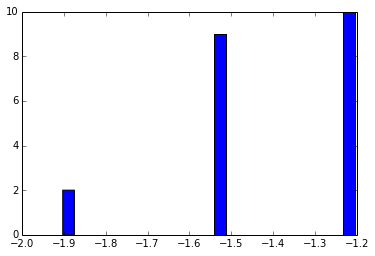

In [74]:
histo = hist(l_walk, bins=25)

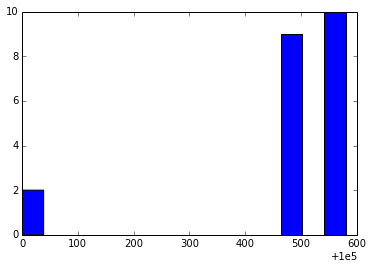

In [70]:
histo = hist(tau_walk, bins=15)